In [28]:
import pandas as pd
import numpy as np
import datetime
from time import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from scipy import stats

## I. Import data

In [2]:
IpAddress_to_Country=pd.read_excel("./Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx")
IpAddress_to_Country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [3]:
fraud_data=pd.read_csv("./Candidate_tech_evaluation_candidate_copy_data science_fraud.csv", index_col="user_id")
fraud_data.head()

,Unnamed: 0,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
user_id,,,,,,,,,,,
285108,149671,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
131009,15611,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
328855,73178,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
229053,84546,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
108439,35978,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [18]:
# get ratio about prediction target
fraud_data["class"].value_counts()

0    108735
1     11265
Name: class, dtype: int64

## II. Feature Engineering
### 1. Convert `ip_address` to `country`

`ip_address` is unique for every device and could be different across different dataset. It is a feature that the machine learning algorithm is likely to overfit on, which means, the algorithm can only correctly label a purchase if the `ip_address` has occured in its training data before otherwise the algorithm can not make correct prediction. Therefore, the information learnt using `ip_address` is hard to generalize on test dataset. Transforming `ip_address` to country names overcome this drawback.


In [4]:
# convert ip to country
# TODO: this step took long, should be able to speed up
def ip_to_country(ip):
    match = (ip >= IpAddress_to_Country['lower_bound_ip_address']) & ( ip <= IpAddress_to_Country['upper_bound_ip_address'])
    if match.any():
        return IpAddress_to_Country['country'][match].to_string(index=False)
    else:
        return 'unknown'
fraud_data['country'] = fraud_data['ip_address'].apply(lambda x: ip_to_country(x))
# fraud_data.head()

In [13]:
# explore country
country_count=fraud_data["country"].value_counts()
country_count.describe()

count      177.000000
mean       677.966102
std       3802.744635
min          1.000000
25%          5.000000
50%         23.000000
75%        198.000000
max      46184.000000
Name: country, dtype: float64

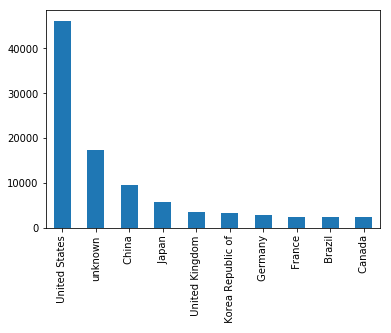

In [17]:
# plot top 10 highest frequent countries
country_count[0:10].plot(kind='bar')

### 2. Transform `signup_time` and `purchase_time`.
Similiar to `ip_address`,  `signup_time` and `purchase_time` are unique and can not be generalized to future data. Tansforming them to the time between sign-up and first purchase solves this issue. As shown in the box-plot below, transformed time can be a strong indicator for detecting fraud.

In [5]:
# signup_to_purchase in hours
purchase_time = fraud_data['purchase_time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
signup_time = fraud_data['signup_time'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
fraud_data['signup_to_purchase']= purchase_time - signup_time
fraud_data['signup_to_purchase'] = fraud_data['signup_to_purchase'].apply(lambda x: x.total_seconds()/3600)
# fraud_data.head()

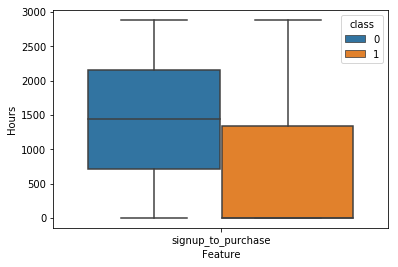

In [7]:
# plot time vs class
fraud_long=pd.melt(fraud_data[['signup_to_purchase','class']], "class", var_name="Feature", value_name="Hours")
sns.boxplot(x="Feature", y="Hours", hue="class",data=fraud_long)

### 3. Explore `device_id` 
Similiar to `ip_address`, `devive_id` is mostly unique and it will likely to cause overfitting. There is no good way to transform this feature therefore it is excluded from modeling. 

In [8]:
# explore device_id
device_count=fraud_data["device_id"].value_counts()
device_count.describe()

count    110599.000000
mean          1.085001
std           0.703870
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          19.000000
Name: device_id, dtype: float64

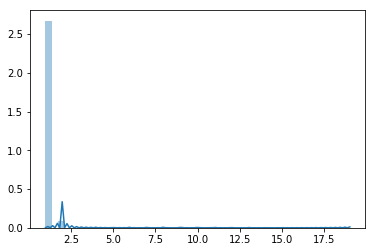

In [9]:
# plot freq 
sns.distplot(sorted(device_count.values))

### 4. Finalize Data Cleaning
Un-used features are dropped and the cleaned data is wrote out for convenice.

In [10]:
# check if any Nan/missing
fraud_data.isnull().values.any()

False

In [11]:
# clean up 
fraud_data.drop(['Unnamed: 0','device_id', 'signup_time', 'purchase_time', 'ip_address'], axis=1, inplace=True)
fraud_data.head()

,purchase_value,source,browser,sex,age,class,country,signup_to_purchase
user_id,,,,,,,,
285108,31,Direct,Chrome,M,49,0,United States,1377.683333
131009,31,SEO,IE,F,21,0,United Kingdom,1888.400000
328855,16,Direct,IE,M,26,0,United States,611.483333
229053,29,SEO,Chrome,M,34,0,Korea Republic of,44.883333
108439,26,Ads,FireFox,M,33,0,Brazil,1433.250000


In [12]:
# wirte intermediate data out for convenice 
fraud_data.to_csv(r'./fraud_data_cleaned.csv')

## III. Modeling
Three classifers are tested: Random Forest, Logistic Regression, and Gradient Boost.
Metrics used for evaluating the models include:
- Accuracy: proportion of true results, range from +1 to 0 (+1 being the best and 0 being the worst).
- Precision: positive predictive value, range from +1 to 0 (+1 being the best and 0 being the worst).
- Recall: true positive rate, range from +1 to 0 (+1 being the best and 0 being the worst).
- F1 score: harmonic mean of precision and recall, range from +1 to 0 (+1 being the best and 0 being the worst). Either false positive or false negative could hurt Electronica so F1 score should be considered instead of just Precision or just Recall. 
- Matthews correlation coefficient(MCC): quality of binary (two-class) classifications, range from +1 to -1 (+1 being the best and -1 being the worst).
- Cohen's Kappa: like classification accuracy, except that it is normalized at the baseline of random chance, range from +1 to -1 (+1 being the best and -1 being the worst).



In [24]:
def predict_metrics(y_truth, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_truth, y_pred))
    print("Precision:",metrics.precision_score(y_truth, y_pred))
    print("Recall:",metrics.recall_score(y_truth, y_pred))
    print("F1 score:",metrics.f1_score(y_truth,y_pred))
    print("MCC score:",metrics.matthews_corrcoef(y_truth,y_pred))
    print("Cohen's kappa:",metrics.cohen_kappa_score(y_truth,y_pred))

In [3]:
# reload data if needed
fraud_data=pd.read_csv("./fraud_data_cleaned.csv", index_col="user_id")

In [19]:
# split X Y
Y = fraud_data['class']
X = fraud_data.drop('class',axis=1)
# dummify string features
X_new = pd.get_dummies(X, columns=['source','browser','sex','country'])
x_train, x_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2)

### Random Forest
Random Forest is one of the most accurate learning algorithms available and runs efficiently on large databases. Moreover, random forest gives estimates of what variables are important in the classification.
I tried Random Forest Classifier (20 trees with boostrap) and used `'balanced_subsample'` to determine class weight since the data is highly unbalanced. I used RandomizedSearchCV to found out the best parameters.

In [14]:
rf = RandomForestClassifier(n_estimators=20,n_jobs=-1,class_weight='balanced_subsample')
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_features": range(1,190,20),
              "min_samples_split": range(2, 11,2),
              "criterion": ["gini", "entropy"],
             "max_depth":[5,20,50,None]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(x_train,y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 325.45 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.957 (std: 0.001)
Parameters: {'min_samples_split': 10, 'max_features': 101, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.957 (std: 0.001)
Parameters: {'min_samples_split': 10, 'max_features': 61, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.956 (std: 0.001)
Parameters: {'min_samples_split': 2, 'max_features': 41, 'max_depth': 20, 'criterion': 'entropy'}



In [22]:
# train tree with best par
rf_tuned=RandomForestClassifier(n_estimators=20, class_weight='balanced_subsample',min_samples_split= 10, max_features= 101, max_depth= 5, criterion='entropy')
rf_tuned.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=5, max_features=101,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [33]:
## prediction on training data
print("In-sample:")
y_train_pred=rf_tuned.predict(x_train)
predict_metrics(y_train, y_train_pred)

print("-"*20)
print("Out-of-sample:")
# test model
y_pred=rf_tuned.predict(x_test)
predict_metrics(y_test, y_pred)


In-sample:
Accuracy: 0.9566041666666667
Precision: 0.9997915798249271
Recall: 0.5352599866101316
F1 score: 0.6972383720930233
MCC score: 0.7146280769260164
Cohen's kappa: 0.6761548631952846
--------------------
Out-of-sample:
Accuracy: 0.9550416666666667
Precision: 1.0
Recall: 0.531480677377334
F1 score: 0.6940742840941311
MCC score: 0.7115490732501404
Cohen's kappa: 0.6722450817017983


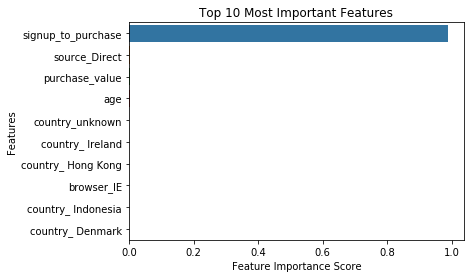

In [25]:
# get feature importance
feature_imp = pd.Series(rf_tuned.feature_importances_,index=X_new.columns).sort_values(ascending=False)
 
# plot most important feautures
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 10 Most Important Features")
plt.show()

### Logistic Regression
Logistic Regression is easy to implement and very efficient in training.
Unfortunately, Logistic regression performed poorly on our dataset compare to Random Forester even though it was faster. I will not consider using this model.

In [26]:
start = time()
lg = LogisticRegression(random_state=0,class_weight='balanced').fit(x_train,y_train)
(time() - start) # training time

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9387636184692383

In [27]:
## prediction on training data
print("In-sample:")
y_train_pred=lg.predict(x_train)
predict_metrics(y_train, y_train_pred)

print("-"*20)
print("Out-of-sample:")
# test model
y_pred=lg.predict(x_test)
predict_metrics(y_test, y_pred)

In-sample:
Accuracy: 0.6547083333333333
Precision: 0.17122505573378283
Recall: 0.7027449230082571
F1 score: 0.2753585169639734
MCC score: 0.2109503484447888
Cohen's kappa: 0.147351097839586
--------------------
Out-of-sample:
Accuracy: 0.64925
Precision: 0.17120120443058393
Recall: 0.691272253582284
F1 score: 0.27443544216514393
MCC score: 0.20317696664558021
Cohen's kappa: 0.14253994258796632


### Gradient Boost
Gradient Boost is similiar to Random Forest other than it builds trees one at a time, where each new tree helps to correct errors made by previously trained tree. With each tree added, the model becomes even more expressive. Grandient boost is more accurate then Random Forester but takes longer to train. 

In [22]:
# train
gb = xgb.XGBClassifier()
gb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [25]:
## prediction on training data
print("In-sample:")
y_train_pred=gb.predict(x_train)
predict_metrics(y_train, y_train_pred)

print("-"*20)
print("Out-of-sample:")
# test model
y_pred=gb.predict(x_test)
predict_metrics(y_test, y_pred)

In-sample:
Accuracy: 0.9564166666666667
Precision: 1.0
Recall: 0.5350594510501167
F1 score: 0.6971188649196467
MCC score: 0.7144986965371637
Cohen's kappa: 0.6759424729151122
--------------------
Out-of-sample:
Accuracy: 0.9558333333333333
Precision: 1.0
Recall: 0.5322153574580759
F1 score: 0.6947004608294931
MCC score: 0.7123661269118118
Cohen's kappa: 0.6732698017764875


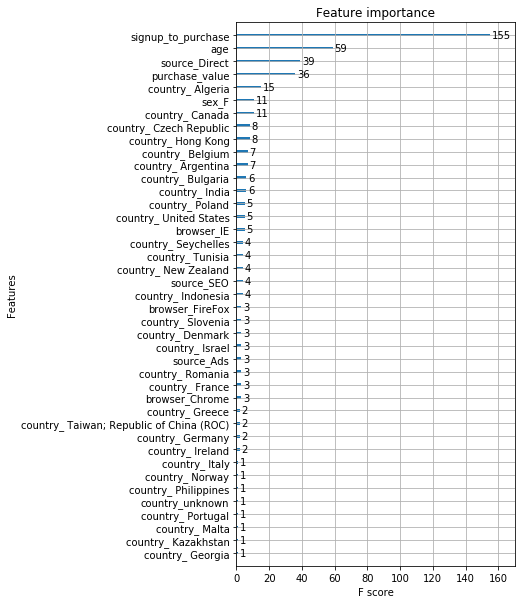

In [73]:
# feature importance
plt.rcParams["figure.figsize"] = (5, 10)
xgb.plot_importance(gb)
plt.show()

# Model MVP: Gradient Boost
Gradient Boost and Random Forest have better performance than Logistic Regression and the scoring of out-of-sample(20%) prediction are shown in the table below. 
Gradient Boost achieved slightly better perforamce as Random Forest did without the computational expensive tuning. Tuning of Gradient Boost, however, took too long on my personal computer, it can be performed on more powerful computers/computer clusters if we want to further imporve the model.

|Metrice | Logistic Regression | Random Forester | Gradient Boost |
|---|----|----|----|
| Accuracy | 0.6493 | 0.9550 | 0.9558 |
| Precision | 0.1712 | 1.0 | 1.0 |
| Recall | 0.6913 | 0.5315 | 0.5322 |
| F1 score | 0.2744 | 0.6941 | 0.6947 |
| MCC score | 0.2032| 0.7115 | 0.7124 |
| Cohen's kappa | 0.1425 | 0.6722 | 0.6732 |

### Future Work
- The features can be further engineered, for example:
    1. `ip_address` can be mapped to states to get more detailed geographic information if the data is availble, especially for the United States because of its highest frequency in the dataset.
    2. `signup_time` and `purchase_time` can be transformed into local time based on user's location and it might be informative because Electronica does wholesale electronics and that usually happens during busniess hours in common sense.
- Tuning of Gradient Boost can be performed to find out the optimal parameters for the model.